In [886]:
using ProgressMeter        # show progress of each loop with: @showprogress 1 "Computing..." for i in 1:50
using Parameters
using Interpolations
using Base.Threads
using Plots
include("functions.jl")

enforce_constraints (generic function with 1 method)

In [921]:

@with_kw mutable struct params
    # Households
    β::Float64  = 0.93     # Discount factor 
    σ::Float64  = 1        # Inverse IES
    ρe::Float64 = 0.910    # Autocorrelation of earnings
    σe::Float64 = 0.92*(1-0.181)     # Cross-sectional std of log earnings
    μe::Float64 = 0.000    # mean of earnings
    min_a::Float64 = 0     # borrowing limit for illiquid asset
    min_b::Float64 = 0    # borrowing limit for liquid asset
    r::Float64  = 0.05     # Real interest rate
    ζ::Float64  = 0.08/(1.05) # Illiquid-liquid spread
    ν::Float64  = 0.089       # Adjustment probability
    θ::Float64  = 0.181       # Retention function curvature
    # Discretization
    na::Int = 50        # Number of grid points for illiquid asset
    nb::Int = 50        # Number of grid points for liquid asset
    nz::Int = 11        # Number of grid points for idiosyncratic income process 
end

pr = params(); #parameters of the model


In [922]:
# Initializing grids
a,b,z,z_p = grid_maker(pr)
z = z/2
pi = stationary(z_p)
y = exp.(z) ./ (pi'*exp.(z));
a'

1×50 adjoint(::Vector{Float64}) with eltype Float64:
 0.0  0.153565  0.330712  0.535063  …  713.39  823.095  949.647  1095.63

In [931]:
# initial guess
A_3d = reshape(a, (1, length(a), 1))
B_3d = reshape(b, (1, 1, length(b)))
Y_3d = reshape(y, (length(y), 1, 1))

Vb_p = (0.05 .* (A_3d.-pr.min_a) .+ 0.2 .* (B_3d.-pr.min_b) .+ 0.2 .* Y_3d) .^ (-pr.σ)
Va_p = 0.8 .* Vb_p .+ (0.1 .+ 0.06 .* (A_3d.-pr.min_a)) .^ (-pr.σ);

Vb_p = repeat(reshape(Vb_p, 1, pr.nz, pr.na, pr.nb),2, 1, 1, 1)
Va_p = repeat(reshape(Va_p, 1, pr.nz, pr.na, pr.nb),2, 1, 1, 1);

In [932]:
total_from_a
temp

550-element Vector{Float64}:
    0.023631261222798478
    0.015357095185021964
   -0.010022208762966387
   -0.06692302663604535
   -0.18395654042867807
   -0.4174542127063449
   -0.8721567112110297
   -1.7325568788553367
   -3.317324253093059
   -6.1821399111365
  -11.308787850843673
    0.016300203609078953
    0.00212472909805478
    ⋮
 -140.34976456206775
 -151.62544599851546
 -151.64757350936267
 -151.6868859164639
 -151.75673106549718
 -151.88082764252388
 -152.10133009629445
 -152.4931805840303
 -153.18968176991703
 -154.42816576685235
 -156.63186922198514
 -160.55768924745894

In [933]:
# EGM

# step 0 *********

Wb_c = (pr.β * Vb_p[1,:,:,:]) .^(-1/pr.σ)
Wa_c = (pr.β * Va_p[1,:,:,:]) .^(-1/pr.σ);

# step 1 *********
# step 1a: find mapping from a to total that makes us indifferent between a and b
total_from_a = zeros(pr.nz*pr.na)
# @threads for i in 1:pr.nz*pr.na
for i in 1:pr.nz*pr.na
    total_from_a[i] = interpolate_f( reshape(Wb_c - Wa_c,:,pr.nb)[i,:], b,0)
end
temp = total_from_a
total_from_a = reshape(total_from_a, pr.nz, pr.na) .+ a'

# step 1b: invert this to get mapping from each current (s, total) to ideal (a,b)
# (use a_grid for totals too, let's assume this is big enough?)
total_from_a_ideal = similar(total_from_a)
# @threads for i in 1:pr.nz
for i in 1:pr.nz
    total_from_a_ideal[i,:] = interpolate_f(total_from_a[i,:], a, a)
end
a_ideal, b_ideal = enforce_constraints(total_from_a_ideal, a[1], b[1], a)

# step 1c: get common marginal value if we do adjust
Vx_c_ideal = zeros(pr.nz,pr.na)
# @threads for i in 1:pr.nz
for i in 1:pr.nz
    func = extrapolate( interpolate((a, b), min.(Wb_c[i,:,:], Wa_c[i,:,:]), Gridded(Linear())), Line())
    Vx_c_ideal[i,:] = func.(a_ideal[i,:], b_ideal[i,:])
end

# step 2 *********
# step 2a: basic one-asset iteration if you can't adjust
b_end,c = backward_core(reshape(Wb_c, :, pr.nb), b, repeat(y, pr.na ), pr )
b_end = reshape(b_end, pr.nz, pr.na, pr.nb)
c = reshape(c, pr.nz, pr.na, pr.nb);


# step 2b: basic one-asset iteration if you will adjust
# (still as function of incoming *total* assets)
total_adjust, c_adjust = backward_core(Vx_c_ideal, a, y, pr)
a_adjust = similar(total_adjust)
b_adjust = similar(total_adjust)
# @threads for i in 1:pr.nz
for i in 1:pr.nz
    a_adjust[i,:] = interpolate_f(a, a_ideal[i,:], total_adjust[i,:])
    b_adjust[i,:] = interpolate_f(a, b_ideal[i,:], total_adjust[i,:])
end

# step 2c: what are a, b, and c if we'll adjust as functions of incoming asset states?
totals = reshape(a .+ b',1,:)
a_adj = similar(Wb_c)
b_adj = similar(Wb_c)
c_adj = similar(Wb_c)
# @threads for i in 1:pr.nz
for i in 1:pr.nz
    a_adj[i,:,:] = interpolate_f(a, a_adjust[i,:], totals)
    b_adj[i,:,:] = interpolate_f(a, b_adjust[i,:], totals)
    c_adj[i,:,:] = interpolate_f(a, c_adjust[i,:], totals)
end

# step 2d: what are marginal values in each case
Va_c = similar(Wa_c)
for i in 1:pr.nz
    # @threads for j in 1:pr.na
    for j in 1:pr.na
        Va_c[i,j,:] = interpolate_f(b, Wa_c[i,j,:], b_end[i,j,:])
    end
end
Vb_c = c
Vx_c_adjust = c_adj

# step 4: move everything from post-return to pre-return grid
a_mat = ones(pr.nz,1,pr.nb) .* ((1+pr.r) .* reshape(a,1,pr.na,1) )
for nm in [Va_c, Vb_c, c, b_end, Vx_c_adjust, c_adj, a_adj, b_adj]
    # @threads for i in 1:pr.nz
    for i in 1:pr.nz
        @eval func = extrapolate( interpolate((a, b), $nm[i,:,:], Gridded(Linear())), Line())
        @eval $nm[i,:,:] = func(a .* (1+pr.r), b .* (1+pr.r).*(1-pr.ζ))
    end
end

# step 5: assemble into full arrays
Va_p = (1 + pr.r) .* cat( reshape(Vx_c_adjust,1,pr.nz,pr.na,pr.nb), reshape(Va_c,1,pr.nz,pr.na,pr.nb); dims=1).^( -pr.σ )
Vb_p = (1 + pr.r) .* (1-pr.ζ) .* cat( reshape(Vx_c_adjust,1,pr.nz,pr.na,pr.nb), reshape(Vb_c,1,pr.nz,pr.na,pr.nb); dims=1).^( -pr.σ )
c_pol = cat( reshape(c_adj,1,pr.nz,pr.na,pr.nb), reshape(c,1,pr.nz,pr.na,pr.nb); dims=1)
b_pol = cat( reshape(b_adj,1,pr.nz,pr.na,pr.nb), reshape(b_end,1,pr.nz,pr.na,pr.nb); dims=1)
a_pol = cat( reshape(a_adj,1,pr.nz,pr.na,pr.nb), reshape(a_mat,1,pr.nz,pr.na,pr.nb); dims=1);


1_2_3_4_5_6_7_8_9_10_11_

In [937]:
Vx_c_adjust[1,:,:] .- Vb_c[1,:,:]

50×50 Matrix{Float64}:
  -0.00341      -0.0132163    -0.0253873   …  -64.1562   -74.023    -85.405
   0.00326721   -0.0104523    -0.0247822      -64.1611   -74.0278   -85.4098
   0.016513     -0.00524331   -0.0239326      -64.1667   -74.0334   -85.4154
   0.0373768     0.00324419   -0.0222385      -64.1731   -74.0399   -85.4218
   0.0621395     0.0143343    -0.0193697      -64.1805   -74.0473   -85.4293
   0.0900243     0.0296081    -0.0134666   …  -64.1891   -74.0559   -85.4379
   0.121684      0.0515573    -0.00189404     -64.199    -74.0658   -85.4478
   0.157842      0.081785      0.017564       -64.2104   -74.0772   -85.4592
   0.199282      0.120502      0.0462423      -64.2236   -74.0904   -85.4723
   0.246879      0.16722       0.084895       -64.2388   -74.1056   -85.4875
   0.301626      0.221787      0.134085    …  -64.2563   -74.1231   -85.5051
   0.364655      0.284794      0.19423        -64.2766   -74.1433   -85.5253
   0.437261      0.357398      0.265671       -64.2999

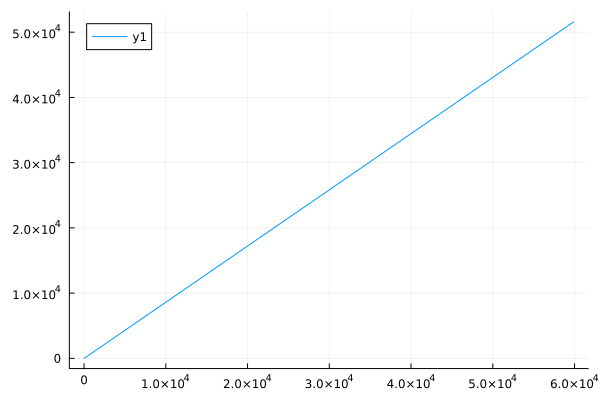

In [870]:
plot(a,total_from_a[11,:])

460.936931383857

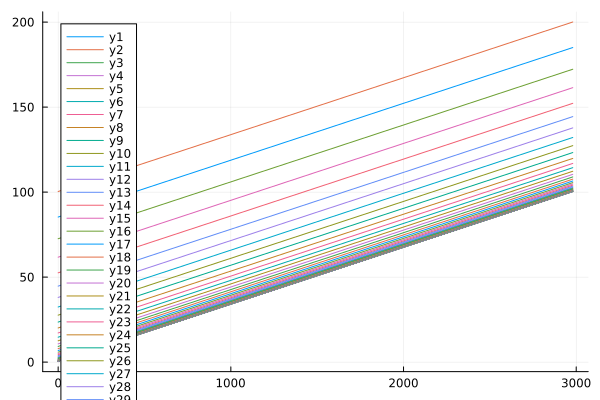

In [683]:
print(maximum(abs.(c_pol - c_pol_old)) )
c_pol_old = copy(c_pol);
plot(a,c_pol[1,10,:,:])


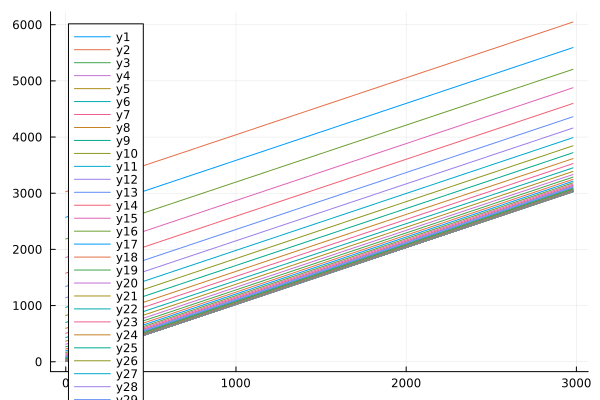

In [675]:
plot(a,b_pol[1,10,:,:])

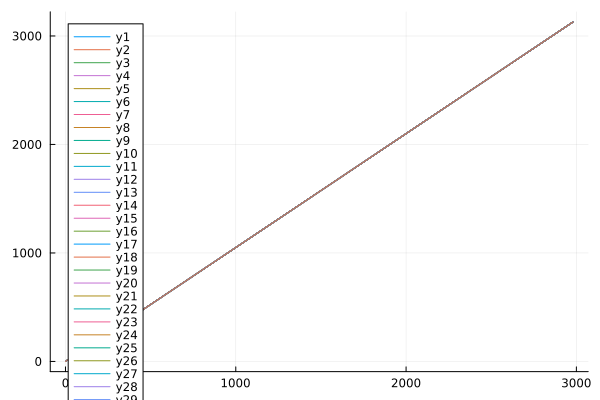

In [670]:
plot(a,a_pol[2,10,:,:])